`Дисциплина: Методы и технологии машинного обучения`   
`Уровень подготовки: бакалавриат`   
`Направление подготовки: 01.03.02 Прикладная математика и информатика`   
`Семестр: осень 2021/2022`   




# Лабораторная работа №4: Методы снижения размерности. Регуляризация логистической регрессии. 
### Работу выполнила студентка ПМИ3-1 Марахова Екатерина, вариант №13.




В практических примерах ниже показано:   

* как снижать размерность пространства признаков методами главных компонент (PCR), частных наименьшах квадратов (PLS)  
* как строить логистическую регрессию с регуляризацией параметров (методы ридж и лассо) 

Точность всех моделей оценивается методом перекрёстной проверки по 10 блокам.  

*Модели*: множественная линейная регрессия 

*Данные*: `default_of_credit_card_clients` (источник: [репозиторий](https://github.com/aksyuk/MTML/blob/main/Labs/data/default_of_credit_card_clients.csv))

*Объясняющие переменные*: все, кроме Y

*Метод снижения размерности*: регрессия на главные компоненты(PCR)

*Метод регуляризации*: ридж-регрессия


# Ход работы


## Загружаем пакеты

In [388]:
# загрузка пакетов: инструменты --------------------------------------------
#  работа с массивами
import numpy as np
#  фреймы данных
import pandas as pd
#  распределение Стьюдента для проверки значимости
from scipy.stats import t
# подсчёт частот внутри массива
from collections import Counter
#  графики
import matplotlib as mpl
#  стили и шаблоны графиков на основе matplotlib
import seaborn as sns

# загрузка пакетов: данные -------------------------------------------------
from sklearn import datasets

# загрузка пакетов: модели -------------------------------------------------
#  стандартизация показателей
from sklearn.preprocessing import StandardScaler
#  метод главных компонент
from sklearn.decomposition import PCA
# метод частных наименьших квадратов
from sklearn.cross_decomposition import PLSRegression
#  логистическая регрессия (ММП)
from sklearn.linear_model import LogisticRegression, LogisticRegressionCV
#  перекрёстная проверка по k блокам
from sklearn.model_selection import KFold, cross_val_score
#  расчёт Acc и сводка по точности классификации
from sklearn.metrics import accuracy_score, classification_report

from sklearn.preprocessing import OrdinalEncoder

# для теста хи-квадрат
import scipy

In [389]:
# константы
#  ядро для генератора случайных чисел
my_seed = 13
#  создаём псевдоним для короткого обращения к графикам
plt = mpl.pyplot
# настройка стиля и отображения графиков
#  примеры стилей и шаблонов графиков: 
#  https://raw.githubusercontent.com/aksyuk/MTML/main/Labs/data/default_of_credit_card_clients.csv
mpl.style.use('seaborn-whitegrid')
sns.set_palette("Set2")
# раскомментируйте следующую строку, чтобы посмотреть палитру
# sns.color_palette("Set2")

In [390]:
# функция, которая строит график сжатия коэффициентов в ридж и лассо
#  из репозитория к книге С.Рашки Python и машинное обучение,
#  слегка переработанная
def plot_coeffs_traces (X, y, class_number, penalty_name, C_opt, col_names,
                        C_min_pow=-4, C_max_pow=3.) :
    fig = plt.figure()
    ax = plt.subplot(111)    
    
    # палитра
    colors = sns.color_palette("Spectral", len(col_names)-1)
    
    weights, params = [], []
    for c in np.arange(C_min_pow, C_max_pow+1):
        lr = LogisticRegression(penalty=penalty_name, 
                                C=10.**c, solver='liblinear', 
                                multi_class='ovr', random_state=my_seed)
        lr.fit(X, y)
        weights.append(lr.coef_[class_number])
        params.append(10**c)

    weights = np.array(weights)

    for column, color in zip(range(weights.shape[1]), colors):
        plt.plot(params, weights[:, column],
                 label=col_names[column],
                 color=color)

    # отсечки по оптимальным C
    plt.axvline(x=C_opt[class_number], color='magenta', 
                linestyle='--', linewidth=1)

    plt.axhline(0, color='black', linestyle='--', linewidth=1)
    plt.xlim([10**(C_min_pow), 10**C_max_pow])
    plt.ylabel('weight coefficient')
    plt.xlabel('C')
    plt.xscale('log')
    plt.legend(loc='upper left')
    ax.legend(loc='upper center', 
              bbox_to_anchor=(1.38, 1.03),
              ncol=1, fancybox=True)
    plt.show()

## Загружаем данные

Данные по кредитам 30000 клиентов банков Тайваня (статистика 2005 года). 

`Задача`: спрогнозировать дефолт платежа в следущем месяце по статистике за 6 предыдущих месяцев и по общим сведениям о клиенте. 

`Источник данных`: статья Yeh, I. C., & Lien, C. H. The comparisons of data mining techniques for the predictive accuracy of probability of default of credit card clients. Expert Systems with Applications, 36(2), 2473-2480. (Набор данных был загружен из репозитория [UCI](https://archive.ics.uci.edu/ml/datasets/default+of+credit+card+clients)).

### Список столбцов файла: 
* `LIMIT_BAL` – размер выданного кредита (новых тайваньских долларов);  
  
  
* `SEX` – пол:  
1 = мужской,   
2 = женский;   

  
* `EDUCATION` – образование:  
1 = аспирантура,   
2 = университет,   
3 = старшая школа,   
4 = другое;  
  
  
* `MARRIAGE` – семейное положение:   
1 = женат/замужем,   
2 = одинок,   
3 = другое;  
  
  
* `AGE` – возраст, лет;  
  
  
* `PAY_0, PAY_2, ..., PAY_6` – статус последних ежемесячных платежей, с сентября (`PAY_0`) по апрель (`PAY_6`) 2005 года:   
\-1 = платёж внесён вовремя,   
1 = платёж внесён с опозданием на 1 месяц;   
2 = с опозданием на 2 месяца,   
и т.д.,   
9 = с опозданием на 9 месяцев и более;  
  
  
* `BILL_AMT1, ..., BILL_AMT6` – размер последних ежемесячных платежей (новых тайваньских долларов), с сентября (`BILL_AMT1`) по апрель (`BILL_AMT6`) 2005 года;  
  
  
* `PAY_AMT1, ..., PAY_AMT6` – размер ежемесячных платежей в предыдущем месяце (новых тайваньских долларов), с сентября (`PAY_AMT1` за август) по апрель (`PAY_AMT6` за март) 2005 года;  
  
  
* `Y` – целевая переменная: дефолт в следующем месяце (1 – да, 0 – нет).


Далее загружаем данные во фрейм,  и выясняем их размерность.  

In [391]:
# загружаем таблицу и превращаем её во фрейм
fileURL = 'https://raw.githubusercontent.com/aksyuk/MTML/main/Labs/data/default_of_credit_card_clients.csv'
DF_all = pd.read_csv(fileURL)

# выясняем размерность фрейма
print('Число строк и столбцов в наборе данных:\n', DF_all.shape)

# смотрим на данные
DF_all.head(5)

Число строк и столбцов в наборе данных:
 (30000, 24)


,LIMIT_BAL,SEX,EDUCATION,MARRIAGE,AGE,PAY_0,PAY_2,PAY_3,PAY_4,PAY_5,...,BILL_AMT4,BILL_AMT5,BILL_AMT6,PAY_AMT1,PAY_AMT2,PAY_AMT3,PAY_AMT4,PAY_AMT5,PAY_AMT6,Y
0,20000,2,2,1,24,2,2,-1,-1,-2,...,0,0,0,0,689,0,0,0,0,1
1,120000,2,2,2,26,-1,2,0,0,0,...,3272,3455,3261,0,1000,1000,1000,0,2000,1
2,90000,2,2,2,34,0,0,0,0,0,...,14331,14948,15549,1518,1500,1000,1000,1000,5000,0
3,50000,2,2,1,37,0,0,0,0,0,...,28314,28959,29547,2000,2019,1200,1100,1069,1000,0
4,50000,1,2,1,57,-1,0,-1,0,0,...,20940,19146,19131,2000,36681,10000,9000,689,679,0


### Подсчет частот категориальных значений.


In [392]:
DF_all['SEX'].unique()

array([2, 1])

In [393]:
np.around(DF_all.SEX.value_counts() / len(DF_all.index), 3)

2    0.604
1    0.396
Name: SEX, dtype: float64

In [394]:
DF_all['EDUCATION'].unique()

array([2, 1, 3, 5, 4, 6, 0])

In [395]:
np.around(DF_all.EDUCATION.value_counts() / len(DF_all.index), 3)

2    0.468
1    0.353
3    0.164
5    0.009
4    0.004
6    0.002
0    0.000
Name: EDUCATION, dtype: float64

In [396]:
DF_all['MARRIAGE'].unique()

array([1, 2, 3, 0])

In [397]:
np.around(DF_all.MARRIAGE.value_counts() / len(DF_all.index), 3)

2    0.532
1    0.455
3    0.011
0    0.002
Name: MARRIAGE, dtype: float64

### ХИ-КВАДРАТ
#### Y и SEX

In [398]:
df_Y_SEX = pd.crosstab(DF_all['Y'], DF_all['SEX'])
df_Y_SEX

SEX,1,2
Y,,
0,9015,14349
1,2873,3763


In [399]:
list_Y_SEX = [[df_Y_SEX[1][0], df_Y_SEX[2][0]], [df_Y_SEX[1][1], df_Y_SEX[2][1]]]

In [400]:
chi2, prob, df, expected = scipy.stats.chi2_contingency(list_Y_SEX)
output = "test Statistics: {}\ndegrees of freedom: {}\np-value: {}\n"
print(output.format(chi2, df, prob))
print(expected)

test Statistics: 47.70879689062111
degrees of freedom: 1
p-value: 4.944678999412044e-12

[[ 9258.3744 14105.6256]
 [ 2629.6256  4006.3744]]


#### Y и EDUCATION

In [401]:
df_Y_EDUCATION = pd.crosstab(DF_all['Y'], DF_all['EDUCATION'])
df_Y_EDUCATION

EDUCATION,0,1,2,3,4,5,6
Y,,,,,,,
0,14,8549,10700,3680,116,262,43
1,0,2036,3330,1237,7,18,8


In [402]:
list_Y_EDUCATION = [[df_Y_EDUCATION[1][0], df_Y_EDUCATION[2][0], 
                     df_Y_EDUCATION[3][0], df_Y_EDUCATION[4][0], 
                     df_Y_EDUCATION[5][0], df_Y_EDUCATION[6][0]], 
                    
                    [df_Y_EDUCATION[1][1], df_Y_EDUCATION[2][1], 
                     df_Y_EDUCATION[3][1], df_Y_EDUCATION[4][1], 
                     df_Y_EDUCATION[5][1], df_Y_EDUCATION[6][1]]]

In [403]:
chi2, prob, df, expected = scipy.stats.chi2_contingency(list_Y_EDUCATION)
output = "test Statistics: {}\ndegrees of freedom: {}\np-value: {}\n"
print(output.format(chi2, df, prob))
print(expected)

test Statistics: 159.18512540464334
degrees of freedom: 5
p-value: 1.4764557605044473e-32

[[ 8242.50483559 10925.11505369  3828.85179751    95.77969719
    218.03508304    39.71353298]
 [ 2342.49516441  3104.88494631  1088.14820249    27.22030281
     61.96491696    11.28646702]]


#### Y и MARRIAGE

In [404]:
df_Y_MARRIAGE = pd.crosstab(DF_all['Y'], DF_all['MARRIAGE'])
df_Y_MARRIAGE

MARRIAGE,0,1,2,3
Y,,,,
0,49,10453,12623,239
1,5,3206,3341,84


In [405]:
list_Y_MARRIAGE = [[df_Y_MARRIAGE[1][0], df_Y_MARRIAGE[2][0], 
                     df_Y_EDUCATION[3][0]], 
                    
                    [df_Y_MARRIAGE[1][1], df_Y_MARRIAGE[2][1], 
                     df_Y_MARRIAGE[3][1]]]

In [406]:
chi2, prob, df, expected = scipy.stats.chi2_contingency(list_Y_MARRIAGE)
output = "test Statistics: {}\ndegrees of freedom: {}\np-value: {}\n"
print(output.format(chi2, df, prob))
print(expected)

test Statistics: 858.2880051332515
degrees of freedom: 2
p-value: 4.2182055954096444e-187

[[10946.18276575 12793.38616827  3016.43106598]
 [ 2712.81723425  3170.61383173   747.56893402]]


### Создание фиктивных переменных.

In [407]:
DF_copy = DF_all.copy()
categorical_cols = ['SEX','EDUCATION','MARRIAGE']
DF_copy = pd.get_dummies(DF_copy, columns = categorical_cols)

#DF_copy = DF_copy.drop(['Y'], axis=1)

In [408]:
DF_copy.head(5)

,LIMIT_BAL,AGE,PAY_0,PAY_2,PAY_3,PAY_4,PAY_5,PAY_6,BILL_AMT1,BILL_AMT2,...,EDUCATION_1,EDUCATION_2,EDUCATION_3,EDUCATION_4,EDUCATION_5,EDUCATION_6,MARRIAGE_0,MARRIAGE_1,MARRIAGE_2,MARRIAGE_3
0,20000,24,2,2,-1,-1,-2,-2,3913,3102,...,0,1,0,0,0,0,0,1,0,0
1,120000,26,-1,2,0,0,0,2,2682,1725,...,0,1,0,0,0,0,0,0,1,0
2,90000,34,0,0,0,0,0,0,29239,14027,...,0,1,0,0,0,0,0,0,1,0
3,50000,37,0,0,0,0,0,0,46990,48233,...,0,1,0,0,0,0,0,1,0,0
4,50000,57,-1,0,-1,0,0,0,8617,5670,...,0,1,0,0,0,0,0,1,0,0


Отложим 15% наблюдений для прогноза.  

In [409]:
# наблюдения для моделирования
DF = DF_copy.sample(frac=0.85, random_state=my_seed)
# отложенные наблюдения
DF_predict = DF_copy.drop(DF.index)

In [410]:
# первые 5 строк фрейма, 17 первых столбцов
DF.iloc[:, :17].head(5)

,LIMIT_BAL,AGE,PAY_0,PAY_2,PAY_3,PAY_4,PAY_5,PAY_6,BILL_AMT1,BILL_AMT2,BILL_AMT3,BILL_AMT4,BILL_AMT5,BILL_AMT6,PAY_AMT1,PAY_AMT2,PAY_AMT3
3195,20000,39,0,0,0,0,2,2,7824,9000,9867,11929,12091,12245,1307,1174,2236
15960,300000,30,0,0,0,0,0,0,217329,206703,203164,164371,161331,154515,8000,20219,7500
17713,120000,30,0,0,0,0,0,0,170263,157881,160796,160168,156165,158850,5520,5700,5815
17897,110000,27,0,0,0,0,0,0,87487,90120,93661,96185,99667,102978,5000,5000,5000
23049,200000,41,1,-1,0,-1,2,0,2217,61328,2877,160944,156864,160066,61634,2877,160944


In [411]:
# первые 5 строк фрейма, 17 последних столбцов
DF.iloc[:, 17:].head(5)

,PAY_AMT4,PAY_AMT5,PAY_AMT6,Y,SEX_1,SEX_2,EDUCATION_0,EDUCATION_1,EDUCATION_2,EDUCATION_3,EDUCATION_4,EDUCATION_5,EDUCATION_6,MARRIAGE_0,MARRIAGE_1,MARRIAGE_2,MARRIAGE_3
3195,500,500,0,0,1,0,0,0,0,1,0,0,0,0,0,1,0
15960,6500,7500,6000,0,0,1,0,1,0,0,0,0,0,0,0,1,0
17713,5500,5522,6000,0,0,1,0,1,0,0,0,0,0,0,0,1,0
17897,5000,5000,4000,0,1,0,0,1,0,0,0,0,0,0,0,1,0
23049,0,5900,13000,1,0,1,0,1,0,0,0,0,0,0,1,0,0


In [412]:
# типы столбцов фрейма
DF.dtypes

LIMIT_BAL      int64
AGE            int64
PAY_0          int64
PAY_2          int64
PAY_3          int64
PAY_4          int64
PAY_5          int64
PAY_6          int64
BILL_AMT1      int64
BILL_AMT2      int64
BILL_AMT3      int64
BILL_AMT4      int64
BILL_AMT5      int64
BILL_AMT6      int64
PAY_AMT1       int64
PAY_AMT2       int64
PAY_AMT3       int64
PAY_AMT4       int64
PAY_AMT5       int64
PAY_AMT6       int64
Y              int64
SEX_1          uint8
SEX_2          uint8
EDUCATION_0    uint8
EDUCATION_1    uint8
EDUCATION_2    uint8
EDUCATION_3    uint8
EDUCATION_4    uint8
EDUCATION_5    uint8
EDUCATION_6    uint8
MARRIAGE_0     uint8
MARRIAGE_1     uint8
MARRIAGE_2     uint8
MARRIAGE_3     uint8
dtype: object

Проверим, нет ли в таблице пропусков.  

In [413]:
# считаем пропуски в каждом столбце
DF.isna().sum()

LIMIT_BAL      0
AGE            0
PAY_0          0
PAY_2          0
PAY_3          0
PAY_4          0
PAY_5          0
PAY_6          0
BILL_AMT1      0
BILL_AMT2      0
BILL_AMT3      0
BILL_AMT4      0
BILL_AMT5      0
BILL_AMT6      0
PAY_AMT1       0
PAY_AMT2       0
PAY_AMT3       0
PAY_AMT4       0
PAY_AMT5       0
PAY_AMT6       0
Y              0
SEX_1          0
SEX_2          0
EDUCATION_0    0
EDUCATION_1    0
EDUCATION_2    0
EDUCATION_3    0
EDUCATION_4    0
EDUCATION_5    0
EDUCATION_6    0
MARRIAGE_0     0
MARRIAGE_1     0
MARRIAGE_2     0
MARRIAGE_3     0
dtype: int64

Пропусков не обнаружено.  
 
 
## Описательные статистики  

#### Считаем доли классов целевой переменной `Y`.  

In [414]:
# метки классов
DF.Y.unique()

array([0, 1])

In [415]:
# доли классов
np.around(DF.Y.value_counts() / len(DF.index), 3)

0    0.781
1    0.219
Name: Y, dtype: float64

#### Рассчитаем для непрерывных переменных набора описательные статистики.

In [416]:
# описательные статистики
DF.iloc[:, :11].describe()

,LIMIT_BAL,AGE,PAY_0,PAY_2,PAY_3,PAY_4,PAY_5,PAY_6,BILL_AMT1,BILL_AMT2,BILL_AMT3
count,25500.000000,25500.000000,25500.000000,25500.000000,25500.000000,25500.000000,25500.000000,25500.000000,25500.000000,25500.000000,2.550000e+04
mean,167848.614902,35.473647,-0.019294,-0.136745,-0.171020,-0.226353,-0.272706,-0.295529,51145.782353,49093.645412,4.689561e+04
std,129894.926164,9.224644,1.125633,1.197933,1.193489,1.167079,1.131698,1.151099,73030.089201,70556.209422,6.893268e+04
min,10000.000000,21.000000,-2.000000,-2.000000,-2.000000,-2.000000,-2.000000,-2.000000,-165580.000000,-69777.000000,-6.150600e+04
25%,50000.000000,28.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,3578.000000,2956.500000,2.635000e+03
50%,140000.000000,34.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,22344.500000,21224.000000,2.003500e+04
75%,240000.000000,41.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,67573.250000,64367.000000,6.031300e+04
max,800000.000000,79.000000,8.000000,8.000000,8.000000,8.000000,8.000000,8.000000,653062.000000,671563.000000,1.664089e+06


In [417]:
# описательные статистики
DF.iloc[:, 11:21].describe()

,BILL_AMT4,BILL_AMT5,BILL_AMT6,PAY_AMT1,PAY_AMT2,PAY_AMT3,PAY_AMT4,PAY_AMT5,PAY_AMT6,Y
count,25500.000000,25500.000000,25500.000000,25500.000000,2.550000e+04,25500.000000,25500.000000,25500.000000,25500.000000,25500.000000
mean,43011.959020,40047.777804,38657.944118,5721.081059,5.912399e+03,5195.790706,4851.610588,4847.703137,5248.818863,0.219216
std,63681.324672,60026.412733,59003.614301,16819.669309,2.259416e+04,16745.180224,15980.476266,15559.835697,17901.580110,0.413723
min,-170000.000000,-81334.000000,-339603.000000,0.000000,0.000000e+00,0.000000,0.000000,0.000000,0.000000,0.000000
25%,2280.000000,1740.750000,1242.000000,1000.000000,8.360000e+02,390.000000,298.750000,243.750000,108.750000,0.000000
50%,19010.000000,18067.000000,17001.500000,2111.500000,2.010000e+03,1826.500000,1500.000000,1500.000000,1500.000000,0.000000
75%,54429.500000,50065.250000,49162.750000,5015.000000,5.000000e+03,4512.750000,4027.000000,4064.250000,4000.000000,0.000000
max,706864.000000,587067.000000,699944.000000,873552.000000,1.684259e+06,889043.000000,621000.000000,426529.000000,528666.000000,1.000000


In [418]:
DF.shape

(25500, 34)

**Выводы по описательным статистикам**: некоторые минимумы значений принимают отрицательные значения, а стандартные отклонения имеют очень большие значения и достаточно большой разброс, что говорит о неоднородности данных. Для работы с методами снижения размерности и регуляризации понадобится стандартизация значений.   

## Визуализация разброса переменных внутри классов  
Построим коробчатые диаграммы для объясняющих переменных, чтобы сравнить средние уровни и разброс по классам.  

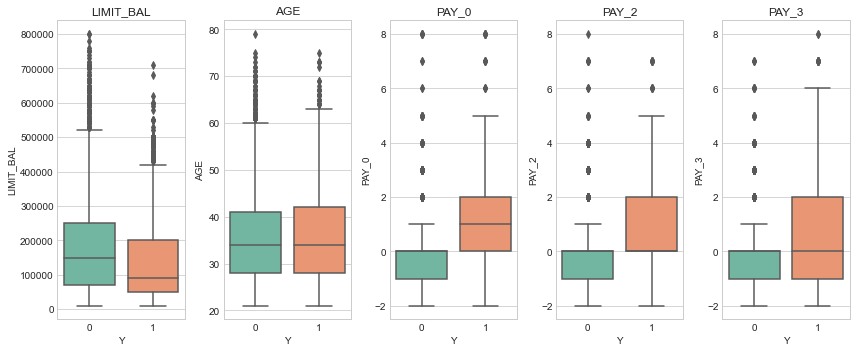

In [419]:
# создаём полотно и делим его на четыре части
fig = plt.figure(figsize=(12, 5))
gs = mpl.gridspec.GridSpec(1, 5)
ax1 = plt.subplot(gs[0, 0])
ax2 = plt.subplot(gs[0, 1])
ax3 = plt.subplot(gs[0, 2])
ax4 = plt.subplot(gs[0, 3])
ax5 = plt.subplot(gs[0, 4])

axs = [ax1, ax2, ax3, ax4, ax5]

cols_loop = list(DF.columns[:5].values)
for col_name in cols_loop :
    i = cols_loop.index(col_name)
    
    sns.boxplot(x='Y', y=col_name, data=DF, ax=axs[i])
    #g = sns.barplot(x='Y', y=col_name, data=DF, ax=axs[i])
    #g.set_yscale("log")
    
    axs[i].set_ylabel(col_name)
    axs[i].set_title(col_name)

# корректируем расположение графиков на полотне
gs.tight_layout(plt.gcf())
plt.show()


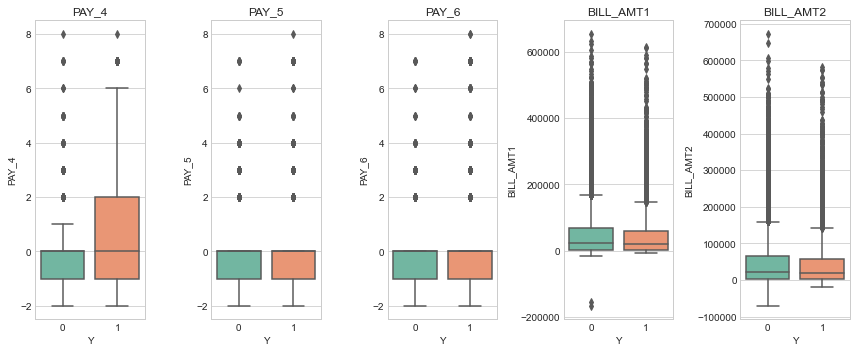

In [420]:
# создаём полотно и делим его на четыре части
fig = plt.figure(figsize=(12, 5))
gs = mpl.gridspec.GridSpec(1, 5)
ax1 = plt.subplot(gs[0, 0])
ax2 = plt.subplot(gs[0, 1])
ax3 = plt.subplot(gs[0, 2])
ax4 = plt.subplot(gs[0, 3])
ax5 = plt.subplot(gs[0, 4])

axs = [ax1, ax2, ax3, ax4, ax5]

cols_loop = list(DF.columns[5:10].values)
for col_name in cols_loop :
    i = cols_loop.index(col_name)
    sns.boxplot(x='Y', y=col_name, data=DF, ax=axs[i])
    #g = sns.barplot(x='Y', y=col_name, data=DF, ax=axs[i])
    #g.set_yscale("log")
    axs[i].set_ylabel(col_name)
    axs[i].set_title(col_name)

# корректируем расположение графиков на полотне
gs.tight_layout(plt.gcf())
plt.show()

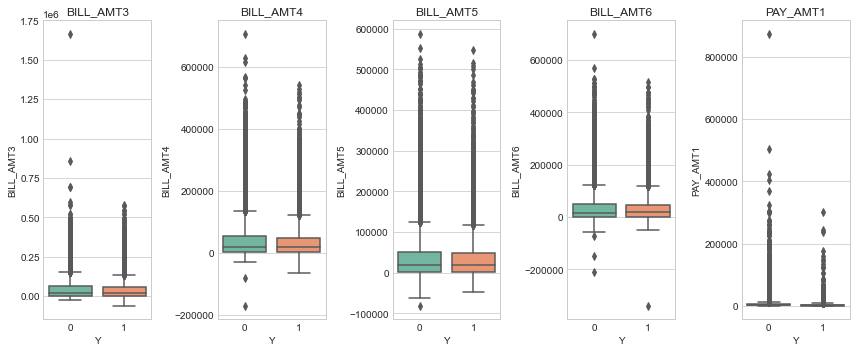

In [421]:
# создаём полотно и делим его на четыре части
fig = plt.figure(figsize=(12, 5))
gs = mpl.gridspec.GridSpec(1, 5)
ax1 = plt.subplot(gs[0, 0])
ax2 = plt.subplot(gs[0, 1])
ax3 = plt.subplot(gs[0, 2])
ax4 = plt.subplot(gs[0, 3])
ax5 = plt.subplot(gs[0, 4])

axs = [ax1, ax2, ax3, ax4, ax5]

cols_loop = list(DF.columns[10:15].values)
for col_name in cols_loop :
    i = cols_loop.index(col_name)
    sns.boxplot(x='Y', y=col_name, data=DF, ax=axs[i])
    #g = sns.barplot(x='Y', y=col_name, data=DF, ax=axs[i])
    #g.set_yscale("log")
    axs[i].set_ylabel(col_name)
    axs[i].set_title(col_name)

# корректируем расположение графиков на полотне
gs.tight_layout(plt.gcf())
plt.show()

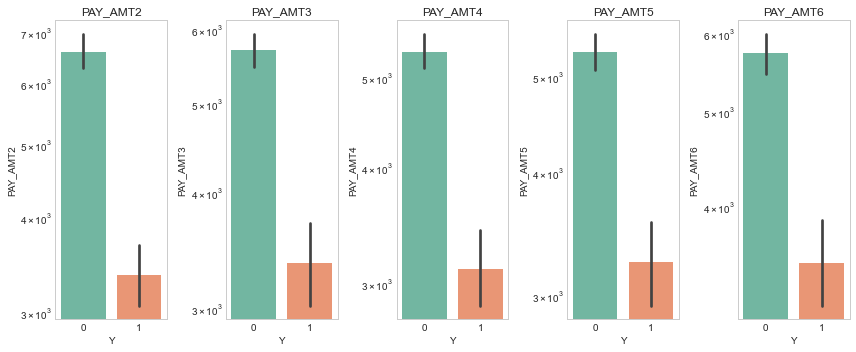

In [422]:
# создаём полотно и делим его на четыре части
fig = plt.figure(figsize=(12, 5))
gs = mpl.gridspec.GridSpec(1, 5)
ax1 = plt.subplot(gs[0, 0])
ax2 = plt.subplot(gs[0, 1])
ax3 = plt.subplot(gs[0, 2])
ax4 = plt.subplot(gs[0, 3])
ax5 = plt.subplot(gs[0, 4])

axs = [ax1, ax2, ax3, ax4, ax5]

cols_loop = list(DF.columns[15:20].values)
for col_name in cols_loop :
    i = cols_loop.index(col_name)
    #sns.boxplot(x='Y', y=col_name, data=DF, ax=axs[i])
    g = sns.barplot(x='Y', y=col_name, data=DF, ax=axs[i])
    g.set_yscale("log")
    axs[i].set_ylabel(col_name)
    axs[i].set_title(col_name)

# корректируем расположение графиков на полотне
gs.tight_layout(plt.gcf())
plt.show()

Только на графиках `PAY_0` и `PAY_2` можно наблюдать хорошее разделение по классам, остальные практически не различаются. Это говорит о том, классы по зависимой переменной `Y` плохо разделяются по всем объясняющим переменным.  

## Корреляционный анализ   

Теперь посмотрим на взаимодействие объясняющих переменных.  

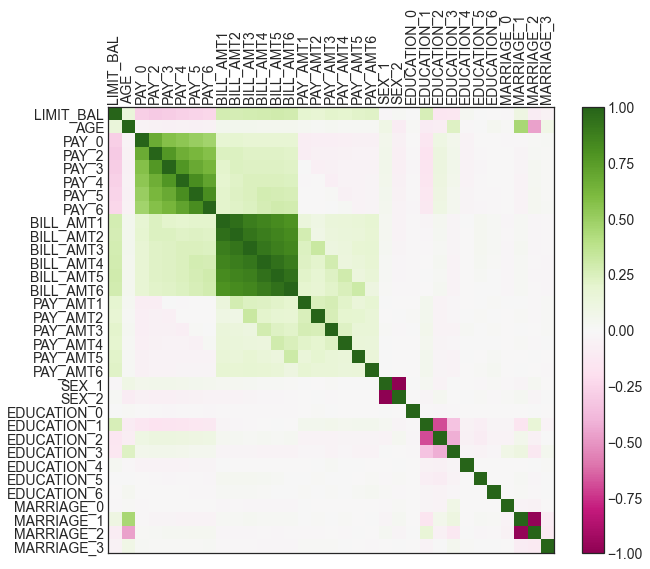

In [423]:
# рассчитываем корреляционную матрицу
corr_mat = DF.drop('Y', axis=1).corr()
col_names = DF.drop('Y', axis=1).columns

# переключаем стиль оформления, чтобы убрать сетку с тепловой карты
mpl.style.use('seaborn-white')

# рисуем корреляционную матрицу
f = plt.figure(figsize=(10, 8))
plt.matshow(corr_mat, fignum=f.number, cmap='PiYG')
# координаты для названий строк и столбцов
tics_coords = np.arange(0, len(col_names))
# рисуем подписи
plt.xticks(tics_coords, col_names, fontsize=14, rotation=90)
plt.yticks(tics_coords, col_names, fontsize=14)
# настраиваем легенду справа от тепловой карты
cb = plt.colorbar()
cb.ax.tick_params(labelsize=14)
cb.ax.tick_params(labelsize=14)
plt.show()

#### Вывод по тепловой карте

Более тесные положительные связи прослеживаются между переменными `BILL_AMT1, BILL_AMT1, ..., BILL_AMT6`, чуть менее тесные положительные - `PAY_0, PAY_1, ..., PAY_6`. 

Также видно и тесные отрицательные связи между `SEX_1` и `SEX_2`, а также `MARRIAGE_1` и `MARRIAGE_2`.

In [424]:
# делаем фрейм из корреляционной матрицы и стираем диагональные значения
#  и нижний треугольник матрицы
df = corr_mat
df = df.where(np.triu(np.ones(df.shape), k=1).astype(bool))
# меняем размерность с матрицы на таблицу: показатель 1, показатель 2,
#  корреляция
df = df.stack().reset_index()
df.columns = ['Показатель_1', 'Показатель_2', 'Корреляция']
# считаем двусторонние p-значения для проверки значимости
t_stat = np.sqrt((len(DF.index) - 2) / (1 - df.Корреляция ** 2))
df['P_значение'] = 2 * (1 - t.cdf(abs(t_stat), len(DF.index) - 2))
# получили все корреляционные коэффициенты без 1 и без повторов
#  выводим все значимые с сортировкой
df.loc[df['P_значение'] < 0.05].sort_values('Корреляция')

/Users/katherine.marakhova/opt/anaconda3/lib/python3.8/site-packages/pandas/core/arraylike.py:358: RuntimeWarning: invalid value encountered in sqrt
  result = getattr(ufunc, method)(*inputs, **kwargs)


,Показатель_1,Показатель_2,Корреляция,P_значение
525,MARRIAGE_1,MARRIAGE_2,-0.975374,0.0
483,EDUCATION_1,EDUCATION_2,-0.690309,0.0
61,AGE,MARRIAGE_2,-0.466652,0.0
492,EDUCATION_2,EDUCATION_3,-0.415212,0.0
484,EDUCATION_1,EDUCATION_3,-0.328761,0.0
...,...,...,...,...
275,BILL_AMT3,BILL_AMT4,0.920791,0.0
252,BILL_AMT2,BILL_AMT3,0.925152,0.0
297,BILL_AMT4,BILL_AMT5,0.938409,0.0
318,BILL_AMT5,BILL_AMT6,0.944524,0.0


Как и было сказано выше, самая сильная обратная связь между `MARRIAGE_1` и `MARRIAGE_2`, а прямая между `BILL_AMT1` и `BILL_AMT2`.

# Частный метод наименьших квадратов (PLS)

### Проведем стандартизацию переменных.  

In [425]:
DF.iloc[:, :23].head(5)

,LIMIT_BAL,AGE,PAY_0,PAY_2,PAY_3,PAY_4,PAY_5,PAY_6,BILL_AMT1,BILL_AMT2,...,BILL_AMT6,PAY_AMT1,PAY_AMT2,PAY_AMT3,PAY_AMT4,PAY_AMT5,PAY_AMT6,Y,SEX_1,SEX_2
3195,20000,39,0,0,0,0,2,2,7824,9000,...,12245,1307,1174,2236,500,500,0,0,1,0
15960,300000,30,0,0,0,0,0,0,217329,206703,...,154515,8000,20219,7500,6500,7500,6000,0,0,1
17713,120000,30,0,0,0,0,0,0,170263,157881,...,158850,5520,5700,5815,5500,5522,6000,0,0,1
17897,110000,27,0,0,0,0,0,0,87487,90120,...,102978,5000,5000,5000,5000,5000,4000,0,1,0
23049,200000,41,1,-1,0,-1,2,0,2217,61328,...,160066,61634,2877,160944,0,5900,13000,1,0,1


In [426]:
# стандартизация
sc = StandardScaler()
df2 = DF.drop('Y', axis=1)
X_train_std = sc.fit_transform(df2.iloc[:, :].values) #тут все переменные кроме зависимой Y

# проверяем средние и стандартные отклонения после стандартизации
for i_col in range(X_train_std.shape[1]) :
    print('Столбец ', i_col, ': среднее = ',
          np.round(np.mean(X_train_std[:, i_col]), 2),
         '   Станд. отклонение = ', 
          np.round(np.std(X_train_std[:, i_col]), 2), sep='')


Столбец 0: среднее = -0.0   Станд. отклонение = 1.0
Столбец 1: среднее = -0.0   Станд. отклонение = 1.0
Столбец 2: среднее = -0.0   Станд. отклонение = 1.0
Столбец 3: среднее = 0.0   Станд. отклонение = 1.0
Столбец 4: среднее = -0.0   Станд. отклонение = 1.0
Столбец 5: среднее = 0.0   Станд. отклонение = 1.0
Столбец 6: среднее = -0.0   Станд. отклонение = 1.0
Столбец 7: среднее = 0.0   Станд. отклонение = 1.0
Столбец 8: среднее = 0.0   Станд. отклонение = 1.0
Столбец 9: среднее = -0.0   Станд. отклонение = 1.0
Столбец 10: среднее = 0.0   Станд. отклонение = 1.0
Столбец 11: среднее = 0.0   Станд. отклонение = 1.0
Столбец 12: среднее = -0.0   Станд. отклонение = 1.0
Столбец 13: среднее = 0.0   Станд. отклонение = 1.0
Столбец 14: среднее = 0.0   Станд. отклонение = 1.0
Столбец 15: среднее = 0.0   Станд. отклонение = 1.0
Столбец 16: среднее = -0.0   Станд. отклонение = 1.0
Столбец 17: среднее = 0.0   Станд. отклонение = 1.0
Столбец 18: среднее = 0.0   Станд. отклонение = 1.0
Столбец 19: ср

#### Посмотрим, как работает метод на всех наблюдениях обучающего набора.  

In [427]:
# функция для оценки модели, берём все компоненты, по числу столбцов X
pls = PLSRegression(n_components=33)
# значения зависимой переменной превращаем в фиктивные по классам
Y_train = pd.get_dummies(DF.Y.astype(str))
# оцениваем
pls.fit(X_train_std, Y_train)

# считаем долю объяснённой дисперсии
frac_var_expl = np.var(pls.x_scores_, axis=0) / np.sum(np.var(X_train_std, axis=0))
print('Доли объяснённой дисперсии по компонентам в PLS:\n',
     np.around(frac_var_expl, 3),
     '\nОбщая сумма долей:', np.around(sum(frac_var_expl), 3))

Доли объяснённой дисперсии по компонентам в PLS:
 [0.128 0.095 0.049 0.047 0.031 0.025 0.03  0.017 0.013 0.013 0.01  0.023
 0.019 0.006 0.015 0.005 0.014 0.008 0.008 0.012 0.008 0.013 0.023 0.009
 0.019 0.002 0.022 0.024 0.021 0.    0.    0.    0.   ] 
Общая сумма долей: 0.711


Из-за того, что при вычислении компонент метдом PLS мы учитываем корреляцию с $Y$, компоненты, во-первых, не ортогональны, а во-вторых сумма объяснённых долей дисперсии уже не равняется 1.  

In [428]:
# сокращаем пространство компонент до 2
pls = PLSRegression(n_components=2)
# перестраиваем модель
pls.fit(X_train_std, Y_train)
# пересчитываем X
X_train_pls = pls.transform(X_train_std)
# предсказываем принадлежности классов для обучающего набора
Y_train_pred = pls.predict(X_train_std)
pd.DataFrame(Y_train_pred)

,0,1
0,0.648386,0.351614
1,0.909772,0.090228
2,0.861796,0.138204
3,0.795555,0.204445
4,0.854777,0.145223
...,...,...
25495,0.456836,0.543164
25496,0.413209,0.586791
25497,0.706284,0.293716
25498,0.991297,0.008703


In [429]:
# вычисляем классы
Y_train_hat = list()
for y_i in Y_train_pred : 
    Y_train_hat.append([i for i in range(len(y_i)) if y_i[i] == max(y_i)][0])
# Y_train_hat
# сколько наблюдений попали в каждый класс по модели
Counter(Y_train_hat).items()

dict_items([(0, 24689), (1, 811)])

Рисуем классы на графике в координатах 2 главных компонент по PLS.  

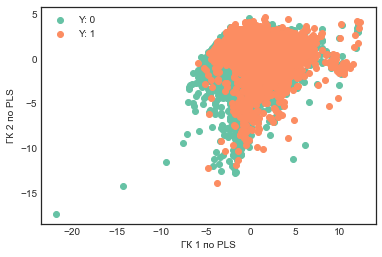

In [430]:
# график классов в пространстве ГК
plt.scatter(X_train_pls[DF['Y'] == 0][:, 0], 
            X_train_pls[DF['Y'] == 0][:, 1], label='Y: 0')
plt.scatter(X_train_pls[DF['Y'] == 1][:, 0], 
            X_train_pls[DF['Y'] == 1][:, 1], label='Y: 1')

plt.xlabel('ГК 1 по PLS')
plt.ylabel('ГК 2 по PLS')
plt.legend()
plt.show()

Видно, что в координатах двух компонент, рассчитанных методом частных наименьших квадратов, классы оказываются достаточно хорошо разделимыми.  
Теперь оценим точность модели с перекрёстной проверкой.  

In [431]:
# функция разбиения на блоки для перекрёстной проверки
#  для чистоты эксперимента возьмём другое ядро генератора случайных чисел
kf_10 = KFold(n_splits=10, random_state=my_seed+1, shuffle=True)
# считаем точность модели (Acc) с перекрёстной проверкой по блокам
#  функция cross_val_score не сработает, т.к. у нас мультиклассовая
#  классификация, поэтому делаем вручную
# значения Y как метки классов
Y_train = DF.Y.values
# значения Y как фиктивные переменные
Y_train_dummy = pd.get_dummies(Y_train.astype(str))
# модель внутри блока
pls_cv = PLSRegression(n_components=2)
# для записи Acc по блокам
acc_blocks = list()
# цикл по блокам
for train_index, test_index in kf_10.split(X_train_std, DF.Y.values) : 
    # данные для модели внутри блока
    X_i_train = X_train_std[train_index]
    Y_i_train = Y_train_dummy.iloc[train_index, :]

    # данные для прогноза вне блока
    X_i_test = X_train_std[test_index]
    Y_i_test = Y_train[test_index]

    # оцениваем модель на блоке
    pls_cv.fit(X_i_train, Y_i_train)
    # делаем прогноз y вне блока
    Y_pred = pls.predict(X_i_test)
    Y_hat = list()
    for y_i in Y_pred : 
        Y_hat.append([i for i in range(len(y_i)) if y_i[i] == max(y_i)][0])
    # считаем точность
    acc = accuracy_score(Y_i_test, Y_hat)
    acc_blocks.append(acc)

score = list()
score.append(np.around(np.mean(acc_blocks), 3))
score_models = list()
score_models.append('logit_PLS')
print('Модель ', score_models[0], ', перекрёстная проверка по 10 блокам',
      '\nAcc = ', np.around(score[0], 2), sep='')



Модель logit_PLS, перекрёстная проверка по 10 блокам
Acc = 0.8


# Методы сжатия  

## Ридж-регрессия  

Функция `LogisticRegression()` умеет работать с мультиклассовой классификацией, используя при оценке параметров подход **один класс против остальных**. Построим ридж на наших данных.  

In [432]:
# функция для построения модели
logit_ridge = LogisticRegression(penalty='l2', solver='liblinear')
# оцениваем параметры
logit_ridge.fit(X_train_std, Y_train)
# выводим параметры
print('Константы моделей для классов:\n', np.around(logit_ridge.intercept_, 3),
     '\nКоэффициенты моделей для классов:\n', np.around(logit_ridge.coef_, 3))

Константы моделей для классов:
 [-1.484] 
Коэффициенты моделей для классов:
 [[-0.095  0.06   0.64   0.111  0.075  0.026  0.042  0.004 -0.421  0.224
   0.081 -0.033  0.031  0.021 -0.216 -0.207 -0.042 -0.073 -0.049 -0.033
   0.029 -0.029 -0.124  0.042  0.002 -0.007 -0.058 -0.128  0.004 -0.055
   0.045 -0.04   0.001]]


In [433]:
logit_ridge.intercept_

array([-1.48414442])

Подбираем гиперпараметр регуляризации $\lambda$ с помощью перекрёстной проверки. В функции 
`LogisticRegression()` есть аргумент $C$ – это инверсия гиперпараметра $\lambda$.   

In [434]:
# поиск оптимального значения C:
#  подбираем C по наибольшей точности с перекрёстной проверкой
ridge_cv = LogisticRegressionCV(cv=10, random_state=my_seed+2, 
                                penalty='l2', solver='liblinear')
ridge_cv.fit(X_train_std, Y_train)
# значения параметра C (инверсия лямбды), которые дают наилучшую
#  точность для каждого класса
ridge_cv.C_

array([0.35938137])

In [435]:
# сохраняем и выводим Acc для модели
score.append(np.around(ridge_cv.score(X_train_std, Y_train), 3))
score_models.append('logit_ridge')
print('Модель ', score_models[1], ', перекрёстная проверка по 10 блокам',
      '\nAcc = ', score[1], sep='')

Модель logit_ridge, перекрёстная проверка по 10 блокам
Acc = 0.813


Изобразим изменение коэффициентов ридж-регрессии на графике и сделаем отсечку на уровне оптимального параметра $C$.  

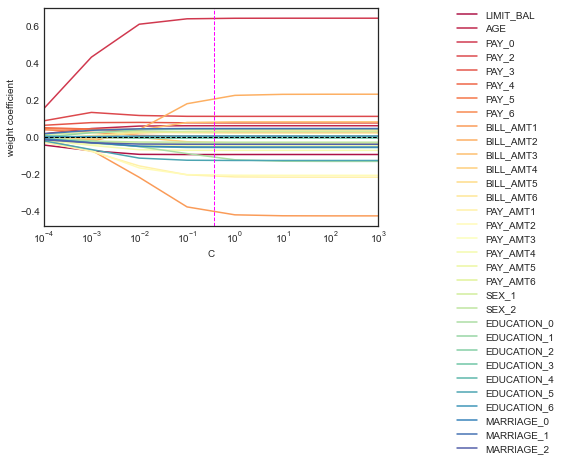

In [438]:
# график динамики коэффициентов в ридж-регрессии    
#  модель для класса 0
DF = DF.drop('Y', axis = 1)
plot_coeffs_traces(X_train_std, Y_train, 0, 'l2', ridge_cv.C_, DF.columns)

# Прогноз на отложенные наблюдения по лучшей модели

Ещё раз посмотрим на точность построенных моделей.  

In [336]:
# сводка по точности моделей
pd.DataFrame({'Модель' : score_models, 'Acc' : score})

,Модель,Acc
0,logit_PLS,0.795
1,logit_ridge,0.811


Все модели показывают высокую точность по показателю $Acc$, при этом самой точной оказывается ридж-регрессия. Сделаем прогноз на отложенные наблюдения.   

In [337]:
# формируем объекты с данными отложенной выборки
X_pred_std = sc.fit_transform(DF_predict.iloc[:, :23].values)
Y_pred = DF_predict.Y
Y_hat = logit_ridge.predict(X_pred_std)
# отчёт по точности на отложенных наблюдениях
print(classification_report(Y_pred, Y_hat))

ValueError: X has 23 features per sample; expecting 22

Таким образом, методом логистической регрессии со сжатием коэффициенты с L2-регуляризацией мы получили модель классификации для двух видов дефолта.

# Источники 

1. *Рашка С.* Python и машинное обучение: крайне необходимое пособие по новейшей предсказательной аналитике, обязательное для более глубокого понимания методологии машинного обучения / пер. с англ. А.В. Логунова. – М.: ДМК Пресс, 2017. – 418 с.: ил.  
1. Репозиторий с кодом к книге *Рашка С.* Python и машинное обучение / github.com. URL: <https://github.com/rasbt/python-machine-learning-book-3rd-edition>  
1. *Xueting Bai*, *Lingbo Wang*, *Hanning Li* Identification of red wine categories based on physicochemical properties / 2019 5th International Conference on Education Technology, Management and Humanities Science (ETMHS 2019). URL: <https://webofproceedings.org/proceedings_series/ESSP/ETMHS%202019/ETMHS19309.pdf>  

